In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [16]:
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Get the last date valid in database.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Get the date before last date a year.
from_date = datetime.strptime(str(last_date),"%Y-%m-%d") - dt.timedelta(days=365)
start_date = from_date.strftime('%Y-%m-%d')
# Perform a query to retrieve the data and precipitation scores
one_year_precipitation = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= from_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
data_analysis = pd.DataFrame(one_year_precipitation)
data_analysis = data_analysis.dropna().set_index("date")

#Sort the dataframe by date
prec_data = data_analysis.sort_index()

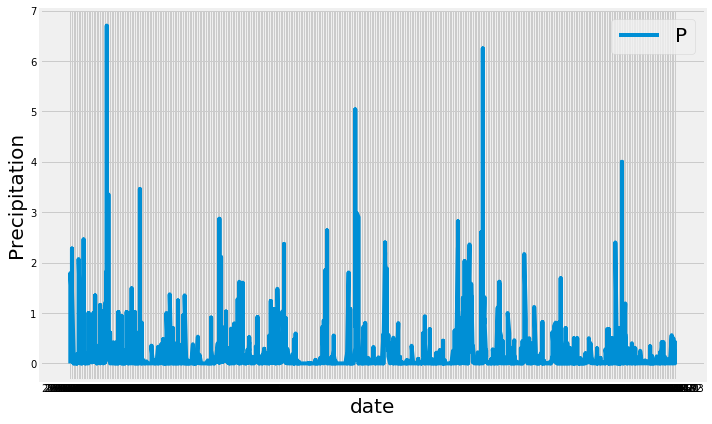

In [201]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=[10,6])
plt.plot(prec_data.index,prec_data.prcp)
plt.xlabel("date",fontsize = 20)
plt.ylabel("Precipitation",fontsize =20)
plt.legend("Precipitation",loc='upper right', fontsize=20)
# Save the figure
plt.tight_layout()
plt.savefig("Images/precipiration.png")
plt.show()

In [203]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [35]:
# Design a query to show how many stations are available in this dataset?
number_station = session.query(Station.station).count()
number_station

9

In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
list_station = session.query(Measurement.station,Measurement.tobs).all()
list_station = pd.DataFrame(list_station).groupby("station").count().sort_values("tobs", ascending = False)
list_station

,tobs
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [40]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# The first solution
# Get the most active station
mostactive_station = list_station.index[0]
data_query = session.query(Measurement.tobs).filter(Measurement.station == mostactive_station)
# Process data in pandas
max_temp = pd.DataFrame(data_query).max()
min_temp = pd.DataFrame(data_query).min()
avg_temp = pd.DataFrame(data_query).mean()

statis_temp = [(min_temp[0], max_temp[0], avg_temp[0])]
statis_temp

[(54.0, 85.0, 71.66378066378067)]

In [39]:
#The second solution
data_query1 = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == list_station.index[0])
for data in data_query1:
    print([data])

[(54.0, 85.0, 71.66378066378067)]


In [41]:
# Choose the station with the highest number of temperature observations.
# Query the database
highest_station_observation = session.query(Measurement.station,Measurement.tobs)
# Transform the query into dataframe and groupby "station"
df_observation =pd.DataFrame(highest_station_observation).groupby("station").count().\
sort_values("tobs", ascending = False)
high_obser_station = df_observation.index[0]
high_obser_station

'USC00519281'

In [42]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12month = session.query(Measurement.tobs).filter(Measurement.station == high_obser_station).\
filter(Measurement.date >= from_date.strftime('%Y-%m-%d'))
last_12month = pd.DataFrame(last_12month)
last_12month.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


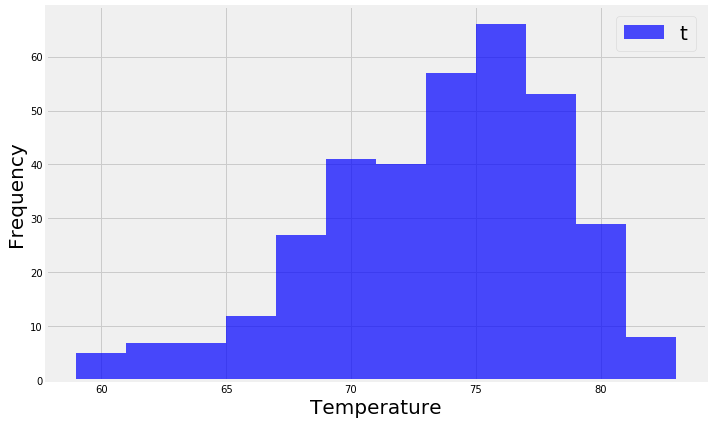

In [44]:
#Plot the histogram of a year temperature observation.
plt.figure(figsize=[10,6])
x=last_12month['tobs']
n, bins, patches = plt.hist(x, bins= 12, color='blue', alpha=0.7)
plt.ylabel("Frequency",fontsize =20)
plt.xlabel("Temperature",fontsize =20)
plt.legend("tobs",loc='upper right', fontsize=20)

plt.tight_layout()
plt.savefig("Images/tobs_ayear.png")
plt.show()

In [45]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# I choose the trip dates from "2016-07-01" to "2016-07-18"
start_day = "2016-07-01"
end_day = "2016-07-18"
trip_temp = calc_temps(start_day,end_day)
trip_temp
trip_temp[0][1]

77.04464285714286

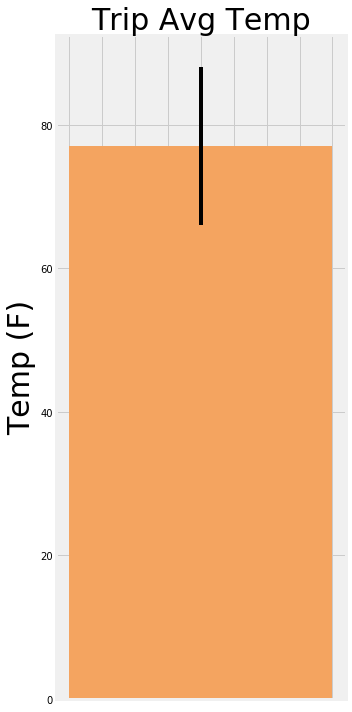

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig,ax=plt.subplots(figsize=[5,10])
plt.bar(0,trip_temp[0][1],color ="sandybrown",yerr = (trip_temp[0][2] - trip_temp[0][0]))
ax.set_xticklabels([])
plt.ylabel("Temp (F)",fontsize =30)
plt.title("Trip Avg Temp",fontsize =30)

plt.tight_layout()
plt.savefig("Images/Trip_avg_temp.png")
plt.show()

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                              func.sum(Measurement.prcp)).filter(Station.station == Measurement.station).\
                              filter(Measurement.date >= start_day).filter(Measurement.date <= end_day).\
                              group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
for data in trip_rainfall:
    print(data)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 10.4)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.600000000000001)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.51)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.1)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.8900000000000001)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.85)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)


## Optional Challenge Assignment

In [49]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [57]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2016-07-01"
start = datetime.strptime(start_date, "%Y-%m-%d")
end_date = "2016-07-18"
end =datetime.strptime(end_date, "%Y-%m-%d")
# Use the start and end date to create a range of dates
range_dates = [start + dt.timedelta(days=x) for x in range(0, (end - start + dt.timedelta(1)).days)]
range_dates

[datetime.datetime(2016, 7, 1, 0, 0),
 datetime.datetime(2016, 7, 2, 0, 0),
 datetime.datetime(2016, 7, 3, 0, 0),
 datetime.datetime(2016, 7, 4, 0, 0),
 datetime.datetime(2016, 7, 5, 0, 0),
 datetime.datetime(2016, 7, 6, 0, 0),
 datetime.datetime(2016, 7, 7, 0, 0),
 datetime.datetime(2016, 7, 8, 0, 0),
 datetime.datetime(2016, 7, 9, 0, 0),
 datetime.datetime(2016, 7, 10, 0, 0),
 datetime.datetime(2016, 7, 11, 0, 0),
 datetime.datetime(2016, 7, 12, 0, 0),
 datetime.datetime(2016, 7, 13, 0, 0),
 datetime.datetime(2016, 7, 14, 0, 0),
 datetime.datetime(2016, 7, 15, 0, 0),
 datetime.datetime(2016, 7, 16, 0, 0),
 datetime.datetime(2016, 7, 17, 0, 0),
 datetime.datetime(2016, 7, 18, 0, 0)]

In [59]:
# Stip off the year and save a list of %m-%d strings
dates_noyear = []
for dates in range_dates:
    dates_noyear.append(dates.strftime("%m-%d"))    
dates_noyear

['07-01',
 '07-02',
 '07-03',
 '07-04',
 '07-05',
 '07-06',
 '07-07',
 '07-08',
 '07-09',
 '07-10',
 '07-11',
 '07-12',
 '07-13',
 '07-14',
 '07-15',
 '07-16',
 '07-17',
 '07-18']

In [60]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_trip = []
for i in dates_noyear:
    normals_trip.append(daily_normals(i)[0])
normals_trip

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0)]

In [61]:
# Create an index column of dates
trip_dates = [x.strftime("%Y-%m-%d") for x in range_dates]
trip_dates = pd.DataFrame(trip_dates, columns =["date"])
trip_dates.head()

,date
0,2016-07-01
1,2016-07-02
2,2016-07-03
3,2016-07-04
4,2016-07-05


In [62]:
df_normals_trip = pd.DataFrame(normals_trip, columns=["tmin","tavg", 'tmax'])
df_normals_trip.head()

,tmin,tavg,tmax
0,67.0,74.777778,81.0
1,68.0,75.403846,82.0
2,68.0,75.320755,87.0
3,70.0,76.571429,81.0
4,66.0,75.000000,81.0


In [64]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_trip_normals = pd.concat([trip_dates,df_normals_trip],axis =1).set_index('date')
temp_trip_normals


,tmin,tavg,tmax
date,,,
2016-07-01,67.0,74.777778,81.0
2016-07-02,68.0,75.403846,82.0
2016-07-03,68.0,75.320755,87.0
2016-07-04,70.0,76.571429,81.0
2016-07-05,66.0,75.000000,81.0
2016-07-06,69.0,75.000000,81.0
2016-07-07,69.0,74.910714,82.0
2016-07-08,69.0,76.083333,83.0
2016-07-09,68.0,76.192982,83.0


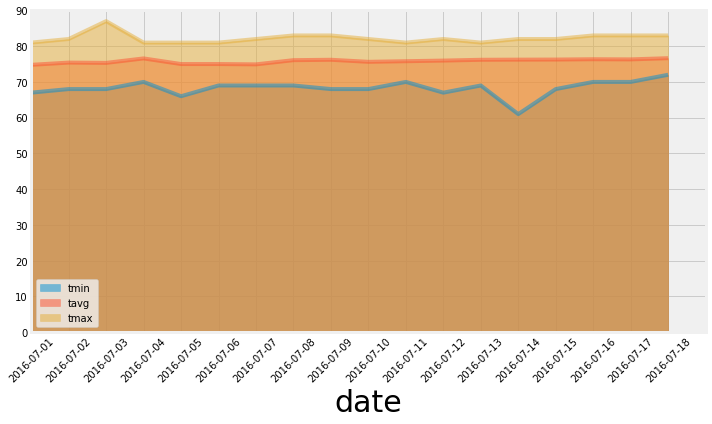

In [65]:
# Plot the daily normals as an area plot with `stacked=False`
temp_trip_normals.plot.area(stacked = False,figsize=[10,6])
plt.ylim(0,90)
plt.xlabel("date",fontsize = 30)
plt.xticks((np.arange(19)),labels = temp_trip_normals.index,rotation = 45)

plt.tight_layout()
plt.savefig("Images/Temp_trip_normals.png")
plt.show()